# Parametrized Quantum Circuits

In this section, we introduce parameterised quantum circuits, then describe their properties and implement some examples used in quantum machine learning. 

## Contents

1. [Introduction](#Introduction)
1. [Parameterized Quantum Circuit Properties](#Parametrized-Quantum-Circuit-Properties)
    1. [Expressibility](#Expressibility)
    1. [Entangling-Capability](#Entangling-Capability)
1. [Parameterized Quantum Circuits for Machine Learning](#Parameterized-Quantum-Circuits-for-Machine-Learning)
1. [References](#References)

## Introduction

As we saw in the [variational quantum classifier](vqc.ipynb) example in the [introduction](introduction.ipynb), parameterized quantum circuits, where the gates are defined through tunable parameters, are a fundamental building block of near-term quantum machine learning algorithms. In the literature, depending on the context, parameterized quantum circuits are also called parameterised trial states, variational forms or ansatze.

Here is an example of a simple parameterised circuit, with two parameterised gates, a single-qubit $z$-rotation gate, with a variable rotation $\theta$, followed by a two-qubit controlled $z$-rotation gate, with the same variable rotation $\theta$: 

<figure>
  <img src="images/pqc.png" style="width:150px">
</figure> 

The parameterized circuit above can be created in Qiskit using the `QuantumCircuit`  and `Parameter` classes. This allows us to create a circuit with rotation gates, without having to specify what the angles are yet:

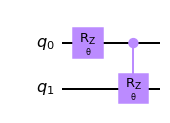

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta,0)
qc.crz(theta,0,1)
qc.draw(output="mpl")

If we want the gates to have different parameters, we can use two `Parameters`, or we create a `ParameterVector`, which acts like a list of `Parameters`:

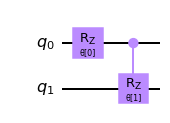

In [2]:
from qiskit.circuit import ParameterVector

theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0],0)
qc.crz(theta_list[1],0,1)
qc.draw(output="mpl")

As all quantum gates used in a quantum circuit are [unitary](gloss:unitary), a parametrized circuit itself can be described as a unitary operation on $n$ qubits, $\mathbf{U_\theta}$, acting on some initial state $|\phi_0\rangle$, often set to $|0\rangle^{\otimes n}$. The resulting parameterized quantum state is $|\psi_\mathbf{\theta}\rangle = \mathbf{U_\theta} |\phi_0\rangle$ where $\mathbf{\theta}$ is a set of tunable parameters.

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-pqc-0") -->

<!-- ::: .question -->

Which of these Qiskit gates can be parametrized?

<!-- ::: -->

<!-- ::: .option -->

1. <code>XGate</code>

<!-- ::: -->

<!-- ::: .option(correct) -->

2. <code>PhaseGate</code>

<!-- ::: -->

<!-- ::: .option -->

3. <code>HGate</code>

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## Parametrized Quantum Circuit Properties

How do we choose one parameterized circuit over the other? To use parameterised quantum circuits as a machine learning model, we need them to generalize well. This means that the selected circuit should be able to generate a significant subset of the states within the output Hilbert space. To avoid being easy to simulate on a classical computer, the selected circuit should ideally also entangle qubits. 

In Reference [1](#references), the authors propose the measures of *expressibility* and *entangling capability* to discriminate between different parameterised quantum circuits. The *expressibility* of a circuit can be understood as the extent to which a parametrized circuit is able to generate states within the Hilbert space, while the *entangling capability* of a circuit describes its ability to generate entangled states.

### *Expressibility*

*Expressibility* of a parameterizes quantum circuit is quantified in Reference [1](#references) by computing the extent to which the states generated from the circuit deviate from the [uniform distribution](gloss:uniform_dist). 

Let's compare the two following single-qubit circuits to get a sense of what it means for a circuit to be expressible or not, by sampling 2000 output states for each circuit and plotting them on a Bloch sphere. 

<figure>
  <img src="images/expr.png" style="width:400px">
</figure> 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit.visualization as qv
import qiskit.quantum_info as qi

First, we need to define the circuits:

In [4]:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

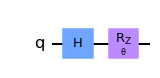

In [5]:
# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param,0)
qc_A.draw(output="mpl")

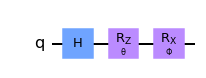

In [6]:
# Circuit B
qc_B=QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param,0)
qc_B.rx(phi_param,0)
qc_B.draw(output="mpl")

Next we uniformly sample the parameter space for the two parameters $\theta$ and $\phi$:

In [7]:
np.random.seed(0)
num_param = 2000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

Then we take the parameter value lists, build the state vectors corresponding to each circuit and plot them on the Bloch sphere:

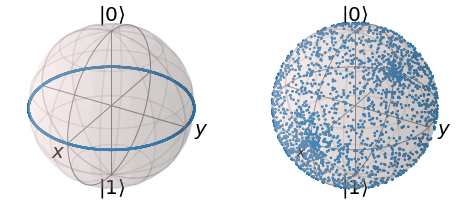

In [8]:
# Converts state vectors to points on the Bloch sphere
def state_to_bloch(state_vec):
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = qv.bloch.Bloch(axes=ax1), qv.bloch.Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=qi.Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=qi.Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

For Circuit A, with a Hadamard gate followed by a parameterizes $z$-rotation gate, we observe output states distributed about the equator of the Bloch sphere (left). With Circuit B, with the additional parameterised $z$-rotation gate, we are able to cover all the Bloch sphere with output states, but the coverage is not uniform; there are concentrations of points on the $+X$ and $-X$ poles of the Bloch sphere.  

Expressibility is a way to quantify what we just observed for these single-qubit circuits. Circuit A would have a low expressibility score due to the limited set of states it can explore, whereas Circuit B would have a high expressibility score.  

### *Entangling Capability*

Entanglement is often seen as a key resource in quantum computing. The Meyer-Wallach measure is one of many metrics that can be used quantify how entangled a given state is. The Meyer-Wallach measure of an unentangled [product state](gloss:product_state) is 0, while the Meyer-Wallach measure of a highly entangled state, such as the Bell state, is 1. In Reference [1](#references), the authors define the entangling capability of a parameterized quantum circuit as the average Meyer-Wallach measure for the states it can generate.

For example, consider the following multi-qubit parameterized circuits:
<figure>
  <img src="images/ent.png" style="width:300px">
</figure> 

Circuit A has no entangling operations, that is, no two-qubit gates, so it has no entangling capability. Thus, this circuit would produce states that have Meyer-Wallach measures of 0, leading to an averaged value of 0. Circuit B has several two-qubit gates and thus is able to generate quantum states with some entanglement. Therefore, the average Meyer-Wallach measure would be greater than 0. 

Using these two parameterized quantum circuit descriptors, expressibility and entangling capability, we can identify circuits that have limited capabilities. We expect that limited circuits are poor candidates for quantum machine learning applications. This was investigated in Reference [2](#references) for the variational quantum classifier; and for their studied datasets and parameterized circuits, it was found that there was a strong correlation between classification accuracy and expressibility, and a weak correlation between classification accuracy entangling capability.

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-pqc-1") -->

<!-- ::: .question -->

Why is entangling capabilty desirable in a quantum circuit?

<!-- ::: -->

<!-- ::: .option(correct) -->

1. Circuits that don't entangle qubits are easy to simulate classically.

<!-- ::: -->

<!-- ::: .option -->

2. Entangling qubits reduces errors in the hardware.

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## Parameterized Quantum Circuits for Machine Learning

In quantum machine learning, parameterized quantum circuits tend to be used for two things: to encode data, where the parameters are determined by the data being encoded, and as a quantum model, where the parameters are determined by an optimization process. Here we will give some examples of how to build parameterized quantum circuits used in the quantum machine learning literature in Qiskit. 

In Reference [3](#references), the authors introduce the following parameterized circuit, used to encode data, which we will study in detail [later](kernel.ipynb):
$$\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$. Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits: $S \in \{\binom{n}{k}\ \text{combinations},\ k = 1,... n \}$, and the data mapping function $\phi_S(\mathbf{x})$ is

$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

Specifically, they use $k = 2, P_0 = Z, P_1 = ZZ$, which in Qiskit is the `ZZFeatureMap` circuit:

{Parameter(x[2]), Parameter(x[0]), Parameter(x[1])}


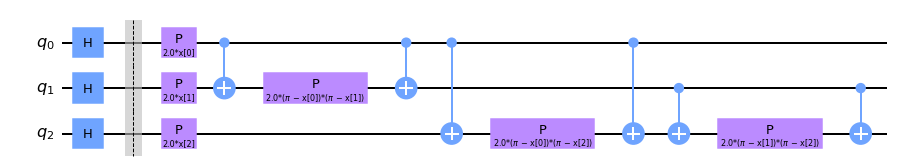

In [9]:
from qiskit.circuit.library import ZZFeatureMap

qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)

print(qc_zz.parameters)
qc_zz.draw(output='mpl')

In Reference [3](#references), the authors also use a hardware efficient circuit as a quantum model, consisting of alternating layers of single-qubit rotation gates, followed by two-qubit gates. In particular, they use $y$-and-$z$-rotation gates, and controlled-$z$ gates, which in Qiskit, can be built using the `TwoLocal` circuit:

{Parameter(θ[8]), Parameter(θ[10]), Parameter(θ[11]), Parameter(θ[3]), Parameter(θ[0]), Parameter(θ[5]), Parameter(θ[1]), Parameter(θ[6]), Parameter(θ[2]), Parameter(θ[9]), Parameter(θ[7]), Parameter(θ[4])}


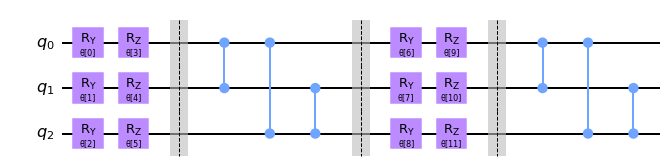

In [10]:
from qiskit.circuit.library import TwoLocal

qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
                entanglement_blocks='cz', skip_final_rotation_layer=True, 
                insert_barriers=True)

print(qc_twolocal.parameters)
qc_twolocal.draw('mpl')

The `TwoLocal` circuit in Qiskit can be used to make many parameterised circuits, such as circuit 13 in Reference [1](#references):

{Parameter(θ[10]), Parameter(θ[6]), Parameter(θ[22]), Parameter(θ[1]), Parameter(θ[18]), Parameter(θ[4]), Parameter(θ[8]), Parameter(θ[23]), Parameter(θ[7]), Parameter(θ[13]), Parameter(θ[0]), Parameter(θ[20]), Parameter(θ[14]), Parameter(θ[19]), Parameter(θ[17]), Parameter(θ[9]), Parameter(θ[12]), Parameter(θ[15]), Parameter(θ[21]), Parameter(θ[16]), Parameter(θ[3]), Parameter(θ[2]), Parameter(θ[5]), Parameter(θ[11])}


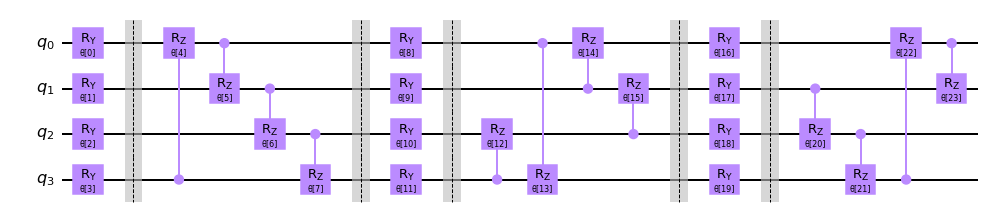

In [11]:
qc_13 = TwoLocal(4, rotation_blocks='ry', entanglement_blocks='crz', entanglement='sca', 
                 reps=3, skip_final_rotation_layer=True, insert_barriers=True)

print(qc_13.parameters)
qc_13.draw('mpl')

The `NLocal` circuit can also be used to create more general parameterized circuits with alternating rotation and entanglement layers. 

Here is a `NLocal` circuit, with a rotation block on 2 qubits and an entanglement block on 4 qubits using linear entanglement:

{Parameter(θ[10]), Parameter(θ[9]), Parameter(θ[12]), Parameter(θ[14]), Parameter(θ[2]), Parameter(θ[6]), Parameter(θ[13]), Parameter(θ[8]), Parameter(θ[11]), Parameter(θ[5]), Parameter(θ[1]), Parameter(θ[4]), Parameter(θ[7]), Parameter(θ[3]), Parameter(θ[0])}


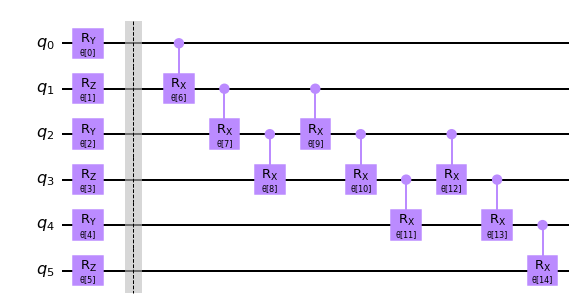

In [16]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
              entanglement='linear', skip_final_rotation_layer=True, insert_barriers=True)
print(qc_nlocal.parameters)
qc_nlocal.draw('mpl')

<!-- ::: q-block.exercise -->

### Try it yourself

Create a circuit that [estimates the phase](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html) introduced by a parametrized RZGate acting on the state $|1\rangle$. Can you plot a graph of the parameter value vs the measured phase?

Try this in the [IBM Quantum Lab](https://quantum-computing.ibm.com/)

<!-- ::: -->

## References <a id="references"></a>

1. Sukin Sim, Peter D. Johnson and Alan Aspuru-Guzik, *Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms*,  	Advanced Quantum Technology 2 (2019) 1900070, [doi:10.1002/qute.201900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), [arXiv:1905.10876](https://arxiv.org/abs/1905.10876).
2. Thomas Hubregtsen, Josef Pichlmeier, and Koen Bertels, *Evaluation of Parameterized Quantum Circuits: On the Design, and the Relation between Classification Accuracy, Expressibility and Entangling Capability* 2020, [arXiv:2003.09887](https://arxiv.org/abs/2003.09887).
3. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table